Running on: cuda


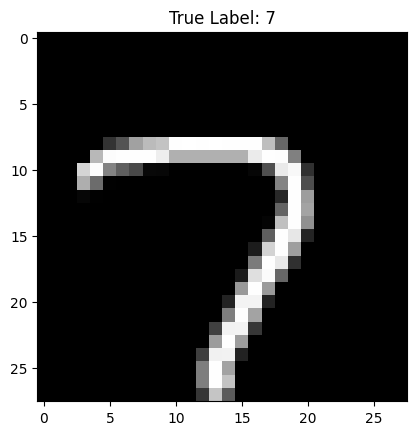

Predicted Label (All Activity): 5
Predicted Label (Proportion Weighting): 5


In [4]:
import torch
from bindsnet.models import DiehlAndCook2015
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from bindsnet.network.monitors import Monitor
from bindsnet.evaluation import all_activity, assign_labels, proportion_weighting



# Parameters (same as during training)
n_neurons = 100  # Replace with the actual number of neurons used in training
time = 250       # Replace with the actual time used during training
dt = 1.0         # Replace with the actual time step
intensity = 128  # Replace with the actual intensity
n_classes = 10   # Number of classes (digits 0-9)

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Initialize the network architecture (same as during training)
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=22.5,    # Replace with actual excitatory current
    inh=120,     # Replace with actual inhibitory current
    dt=dt,
    norm=78.4,   # Replace with actual normalization
    theta_plus=0.05,  # Replace with actual threshold increment
    inpt_shape=(1, 28, 28),  # Input shape for MNIST (channels, height, width)
).to(device)

# Load the saved weights, assignments, proportions, and rates
checkpoint = torch.load('./snn_train.pt')

network.load_state_dict(checkpoint['model_state_dict'])
assignments = checkpoint['assignments'].to(device)
proportions = checkpoint['proportions'].to(device)
rates = checkpoint['rates'].to(device)

# Set the network in evaluation mode
network.train(mode=False)

# Add a spike monitor to the 'Ae' layer
spike_monitor = Monitor(network.layers["Ae"], state_vars=["s"], time=int(time / dt), device=device)
network.add_monitor(spike_monitor, name="Ae_spikes")

# Load the MNIST test dataset
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Get a single sample from the test dataset
sample = test_dataset[1110]  # You can change the index for different samples

# Prepare input for the network (move it to GPU if available)
inputs = {"X": sample["encoded_image"].view(int(time / dt), 1, 1, 28, 28).to(device)}

# Run the network on the input
network.run(inputs=inputs, time=time)

# Record spikes from the excitatory layer
spike_record = torch.zeros((1, int(time / dt), n_neurons), device=device)
spike_record[0] = network.monitors["Ae_spikes"].get("s").squeeze()

# Get the true label from the sample (move to GPU if necessary)
true_label = sample["label"]

# Perform prediction using the all activity strategy
all_activity_pred = all_activity(
    spikes=spike_record,
    assignments=assignments,
    n_labels=n_classes
)

# Perform proportion-based prediction
proportion_pred = proportion_weighting(
    spikes=spike_record,
    assignments=assignments,
    proportions=proportions,
    n_labels=n_classes
)

# Reset state variables
network.reset_state_variables()

# Visualize the input image and print predictions
plt.imshow(sample["image"].view(28, 28).cpu(), cmap="gray")
plt.title(f"True Label: {true_label}")
plt.show()

print(f"Predicted Label (All Activity): {all_activity_pred.item()}")
print(f"Predicted Label (Proportion Weighting): {proportion_pred.item()}")


In [8]:
import torch
from bindsnet.models import DiehlAndCook2015
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
from bindsnet.evaluation import all_activity, proportion_weighting
from bindsnet.network.monitors import Monitor
import os
from tqdm import tqdm

# Parameters (same as during training)
n_neurons = 100  # Replace with the actual number of neurons used in training
time = 250       # Replace with the actual time used during training
dt = 1.0         # Replace with the actual time step
intensity = 128  # Replace with the actual intensity
n_classes = 10   # Number of classes (digits 0-9)

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Initialize the network architecture (same as during training)
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=22.5,    # Replace with actual excitatory current
    inh=120,     # Replace with actual inhibitory current
    dt=dt,
    norm=78.4,   # Replace with actual normalization
    theta_plus=0.05,  # Replace with actual threshold increment
    inpt_shape=(1, 28, 28),  # Input shape for MNIST (channels, height, width)
).to(device)

# Load the saved weights, assignments, proportions, and rates
checkpoint = torch.load('./snn_train.pt')

network.load_state_dict(checkpoint['model_state_dict'])
assignments = checkpoint['assignments'].to(device)
proportions = checkpoint['proportions'].to(device)
rates = checkpoint['rates'].to(device)

# Set the network in evaluation mode
network.train(mode=False)

# Add a spike monitor to the 'Ae' layer
spike_monitor = Monitor(network.layers["Ae"], state_vars=["s"], time=int(time / dt), device=device)
network.add_monitor(spike_monitor, name="Ae_spikes")

# Load the MNIST test dataset
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize counters for correct predictions
correct_all_activity = 0
correct_proportion = 0
total_samples = len(test_loader)

# Run inference on the entire test set
print("\nBegin testing\n")
pbar = tqdm(total=total_samples)

for i, sample in enumerate(test_loader):
    if i ==10:
        break
    # Prepare input for the network (move it to GPU if available)
    inputs = {"X": sample["encoded_image"].view(int(time / dt), 1, 1, 28, 28).to(device)}
    
    # Run the network on the input
    network.run(inputs=inputs, time=time)
    
    # Record spikes from the excitatory layer
    spike_record = torch.zeros((1, int(time / dt), n_neurons), device=device)
    spike_record[0] = network.monitors["Ae_spikes"].get("s").squeeze()

    # Get the true label from the sample (move to GPU if necessary)
    true_label = sample["label"].to(device)

    # Perform prediction using the all activity strategy
    all_activity_pred = all_activity(
        spikes=spike_record,
        assignments=assignments,
        n_labels=n_classes
    )

    # Perform proportion-based prediction
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes
    )

    # Check if the predictions are correct
    correct_all_activity += (all_activity_pred == true_label).float().sum().item()
    correct_proportion += (proportion_pred == true_label).float().sum().item()

    # Reset state variables for the next sample
    network.reset_state_variables()
    
    pbar.update()

pbar.close()

# Calculate accuracy
accuracy_all_activity = 100.0 * correct_all_activity / total_samples
accuracy_proportion = 100.0 * correct_proportion / total_samples

print(f"\nAll Activity Accuracy: {accuracy_all_activity:.2f}%")
print(f"Proportion Weighting Accuracy: {accuracy_proportion:.2f}%")


Running on: cuda

Begin testing



  0%|          | 10/10000 [00:04<1:20:08,  2.08it/s]


All Activity Accuracy: 0.01%
Proportion Weighting Accuracy: 0.02%
